In [34]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import vmap, jit
from fastprogress import progress_bar
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import bayes_ca.inference as core
from bayes_ca.prox_grad import pgd

In [35]:
@jit
def gibbs_sample_subject_means(key,
                         subj_obs, 
                         sigmasq_obs, 
                         global_means, 
                         sigmasq_subj, 
                         mu_pri, 
                         sigmasq_pri, 
                         hazard_rates):
    num_subjects = subj_obs.shape[0]
    effective_sigmasq = 1 / (1 / sigmasq_obs + 1 / sigmasq_subj)
    effective_emissions = effective_sigmasq * (subj_obs / sigmasq_obs + global_means / sigmasq_subj)

    _sample_one = lambda key, y: core.gaussian_cp_posterior_sample(
        key, y, hazard_rates, mu_pri, sigmasq_pri, effective_sigmasq)[1]
    return vmap(_sample_one)(jr.split(key, num_subjects), effective_emissions)

In [36]:
# @jit
def step(key,
         subj_obs, 
         sigmasq_obs, 
         global_means, 
         sigmasq_subj, 
         mu_pri, 
         sigmasq_pri, 
         hazard_rates):
    
    # Sample new subject means
    subj_means = gibbs_sample_subject_means(
        key, subj_obs, sigmasq_obs, global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    
    # Update the global mean
    result = pgd(global_means, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
    global_means = result.x
    
    return global_means, subj_means

## Create data with perfectly aligned subjects

In [37]:
key = jr.PRNGKey(0)

# data settings
num_subjects = 3
num_features = 1
num_timesteps = 300

# model settings
num_states = num_timesteps
max_duration = num_states + 1
hazard_prob = 0.01

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 0.1**2   # Note: variance of jump size is 2 * sigmasq_pri
sigmasq_obs = 0.05**2

hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

mu_pri = core._safe_handling_params(mu_pri, num_features)
sigmasq_pri = core._safe_handling_params(sigmasq_pri, num_features)
sigmasq_subj = core._safe_handling_params(sigmasq_subj, num_features)

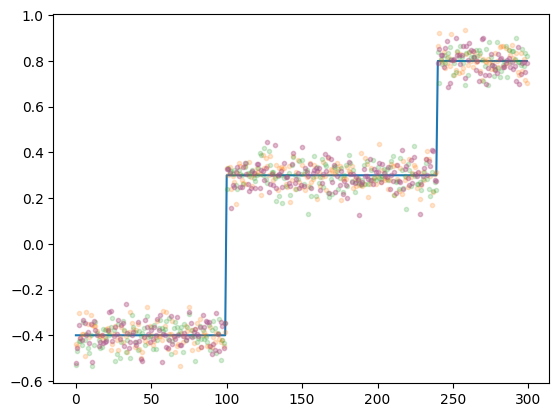

In [38]:
this_key, key = jr.split(key)
signal_one = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((140, 1)) * 0.30,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_one = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=key)

this_key, key = jr.split(key)
obs_two = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)

this_key, key = jr.split(key)
obs_three = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=key)


obs = jnp.stack((obs_one, obs_two, obs_three), axis=0)

plt.plot(signal_one[...,0])
for i in range(4):
    plt.plot(obs[i], '.', alpha=0.2)

In [39]:
key = jr.PRNGKey(0)
init_global_means = jnp.mean(obs, axis=0)
subj_means = gibbs_sample_subject_means(
    key, obs, sigmasq_obs, init_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

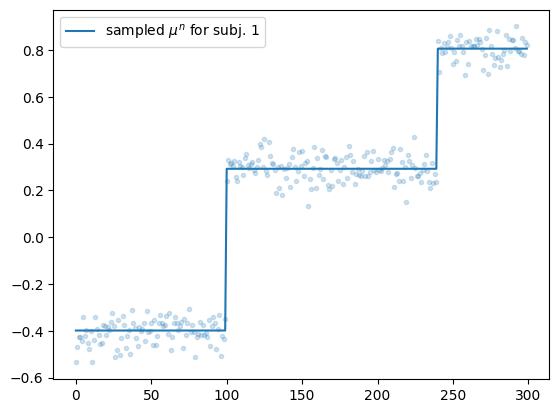

In [40]:
# plt.plot(signals.mean(axis=0))
for i in range(1, 2):
    l = plt.plot(subj_means[i], alpha=1, label=f'sampled $\mu^n$ for subj. {i}')[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

In [41]:
x0 = jnp.ones((num_timesteps, num_features)) * 0.2

result = pgd(x0, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
global_means = result.x

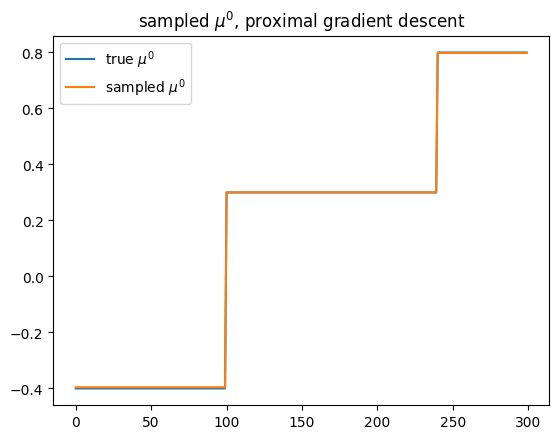

In [42]:
plt.plot(signal_one, label='true $\mu^0$')
plt.plot(global_means, label='sampled $\mu^0$')
# plt.plot(g, ls='-.', label='gradient', alpha=0.8)
plt.title(f'sampled $\mu^0$, proximal gradient descent')
plt.legend()

In [10]:
key = jr.PRNGKey(0)
global_means = jnp.mean(obs, axis=0)

for itr in progress_bar(range(1000)):
    this_key, key = jr.split(key)
    global_means, subj_means = step(
        this_key,
        obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )

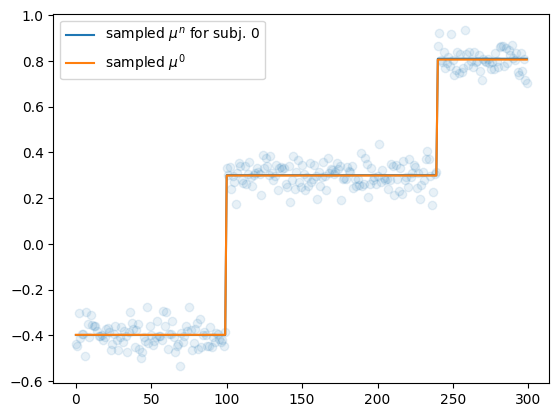

In [11]:
l = plt.plot(subj_means[0], label=f'sampled $\mu^n$ for subj. 0')[0]
plt.plot(obs[0], 'o', color=l.get_color(), alpha=0.1, lw=3)
plt.plot(global_means, label='sampled $\mu^0$')
plt.legend()

## Create data from second schematic figure

In [12]:
key = jr.PRNGKey(0)

# data settings
num_subjects = 3
num_features = 1
num_timesteps = 300

# model settings
num_states = num_timesteps
max_duration = num_states + 1
hazard_prob = 0.01

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 0.5**2   # Note: variance of jump size is 2 * sigmasq_pri
sigmasq_obs = 0.05**2

hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

mu_pri = core._safe_handling_params(mu_pri, num_features)
sigmasq_pri = core._safe_handling_params(sigmasq_pri, num_features)
sigmasq_subj = core._safe_handling_params(sigmasq_subj, num_features)

In [13]:
this_key, key = jr.split(key)
signal_one = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((140, 1)) * 0.30,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_one = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=key)

this_key, key = jr.split(key)
signal_two = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((100, 1)) * 0.30,
        jnp.ones((100, 1)) * 0.80,
    )
)
obs_two = tfd.Normal(signal_two, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)

this_key, key = jr.split(key)
signal_three = jnp.concatenate(
    (
        jnp.ones((240, 1)) * -0.05,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_three = tfd.Normal(signal_three, jnp.sqrt(sigmasq_obs)).sample(seed=key)

In [14]:
signals = jnp.stack((signal_one, signal_two, signal_three), axis=0)
obs = jnp.stack((obs_one, obs_two, obs_three), axis=0)

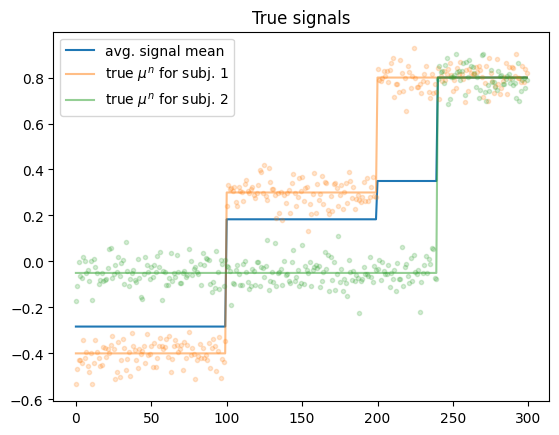

In [15]:
plt.plot(signals.mean(axis=0), label='avg. signal mean')

for i in range(1, 3):
    l = plt.plot(signals[i], alpha=0.5, label=f'true $\mu^n$ for subj. {i}')[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.title("True signals")
plt.legend()
# plt.xlim(0, 250)

## Sample conditional distribution for each subject

The effective observations for each subject are the weighted average of its observations and the global mean.

In [16]:
key = jr.PRNGKey(0)
init_global_means = jnp.mean(obs, axis=0)
subj_means = gibbs_sample_subject_means(
    key, obs, sigmasq_obs, init_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

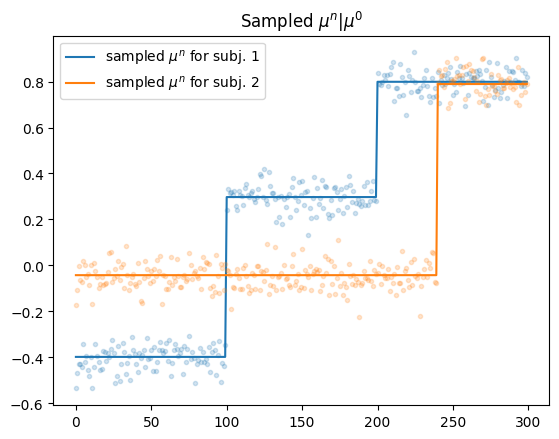

In [17]:
for i in range(1, 3):
    l = plt.plot(subj_means[i], alpha=1, label=f'sampled $\mu^n$ for subj. {i}')[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.title("Sampled $\mu^n | \mu^0$")
plt.legend()

## Compute gradient with respect to the global mean

In [18]:
x0 = jnp.mean(obs, axis=0)

result = pgd(x0, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
global_means = result.x

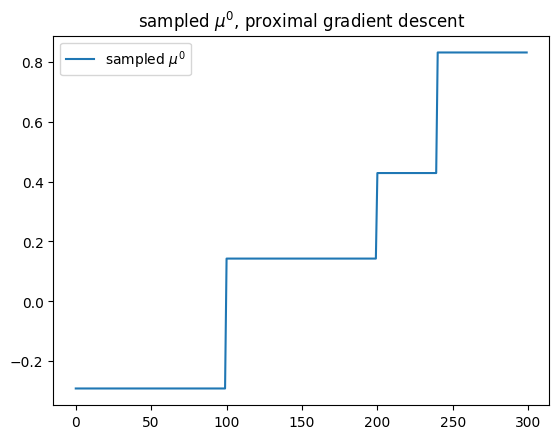

In [22]:
plt.plot(global_means, label='sampled $\mu^0$')
# plt.plot(g, label='gradient', ls='-.', alpha=0.8)
plt.title(f'sampled $\mu^0$, proximal gradient descent')
plt.legend()

## Put both steps together

In [23]:
key = jr.PRNGKey(0)
global_means = jnp.mean(obs, axis=0)

for itr in progress_bar(range(1000)):
    this_key, key = jr.split(key)
    global_means, subj_means = step(
        this_key,
        obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )

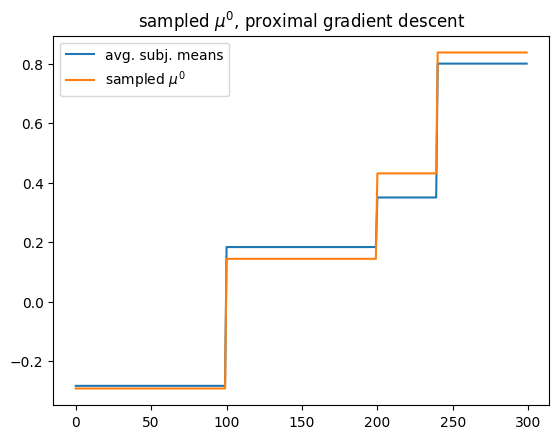

In [24]:
plt.plot(signals.mean(axis=0), label='avg. subj. means')
plt.plot(global_means, label='sampled $\mu^0$')
# plt.plot(g, label='gradient')
# plt.axhline(0.2, color='k', ls='-.')
plt.title(f'sampled $\mu^0$, proximal gradient descent')
plt.legend()

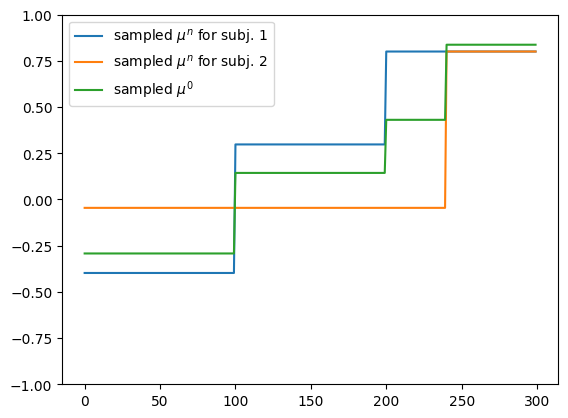

In [25]:
for i in range(1, 3):
    l = plt.plot(subj_means[i], label=f'sampled $\mu^n$ for subj. {i}')[0]
    # plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.plot(global_means, label='sampled $\mu^0$')
plt.legend()

### Compare hyperparameter settings

In [26]:
key = jr.PRNGKey(0)
stepsize = 0.1

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 0.5**2   # Note: variance of jump size is 2 * sigmasq_pri
sigmasq_obs = 0.25**2

In [27]:
this_key, key = jr.split(key)
signal_one = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((140, 1)) * 0.30,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_one = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=key)

this_key, key = jr.split(key)
signal_two = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((100, 1)) * 0.30,
        jnp.ones((100, 1)) * 0.80,
    )
)
obs_two = tfd.Normal(signal_two, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)

this_key, key = jr.split(key)
signal_three = jnp.concatenate(
    (
        jnp.ones((240, 1)) * -0.05,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_three = tfd.Normal(signal_three, jnp.sqrt(sigmasq_obs)).sample(seed=key)

signals = jnp.stack((signal_one, signal_two, signal_three), axis=0)
obs = jnp.stack((obs_one, obs_two, obs_three), axis=0)

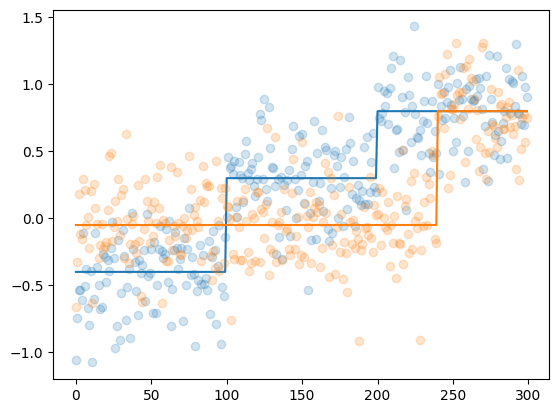

In [28]:
for i in range(1, 3):
    l = plt.plot(signals[i], label=f'sampled $\mu^n$ for subj. {i}')[0]
    plt.plot(obs[i], 'o', color=l.get_color(), alpha=0.2)

In [29]:
global_means = jnp.mean(obs, axis=0)

for itr in progress_bar(range(1000)):
    this_key, key = jr.split(key)
    global_means, subj_means = step(
        this_key,
        obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )

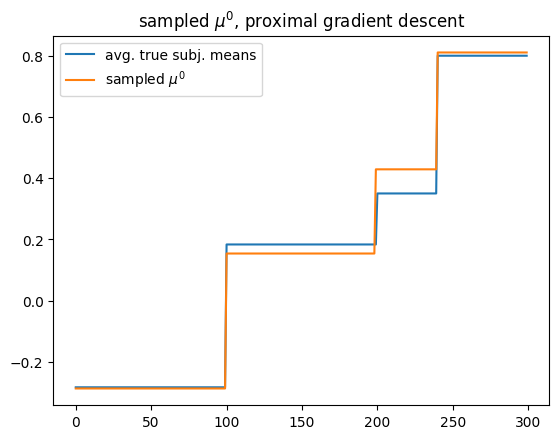

In [30]:
plt.plot(signals.mean(axis=0), label='avg. true subj. means')
plt.plot(global_means, label='sampled $\mu^0$')
# plt.plot(g, label='gradient')
# plt.axhline(0.2, color='k', ls='-.')
plt.title(f'sampled $\mu^0$, proximal gradient descent')
plt.legend()

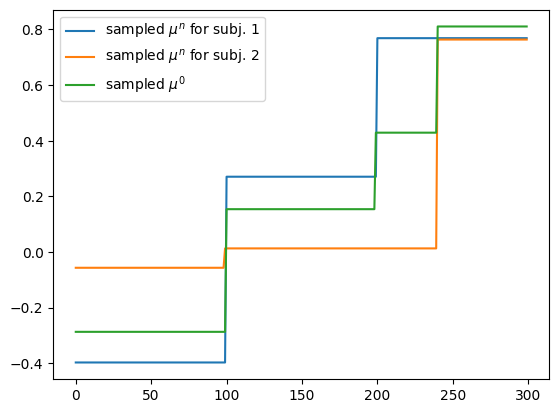

In [31]:
for i in range(1, 3):
    l = plt.plot(subj_means[i], label=f'sampled $\mu^n$ for subj. {i}')[0]
    # plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.plot(global_means, label='sampled $\mu^0$')
# plt.plot(g, '-.', label='gradient', alpha=0.8)
# plt.ylim(-1, 1)
plt.legend()

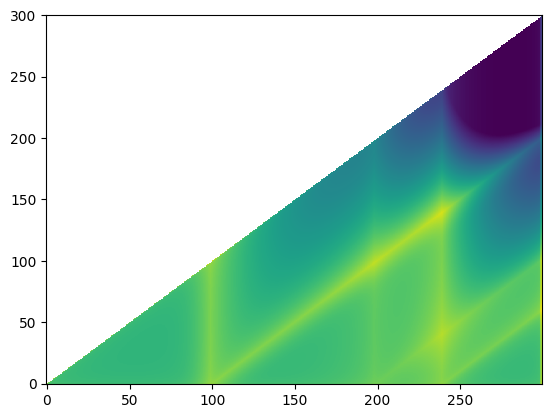

In [32]:
log_normalizer, smoothed_probs, transition_probs, expected_subj_means = core.gaussian_cp_smoother(
    global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)
plt.imshow(jnp.log(transition_probs.T), aspect='auto', origin='lower')

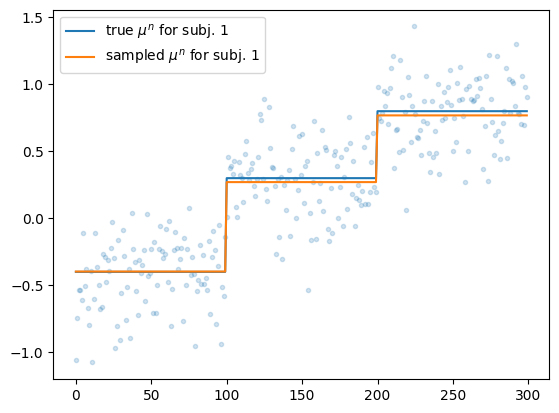

In [33]:
for i in range(1, 2):
    l = plt.plot(signals[i], label=f'true $\mu^n$ for subj. {i}')[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
    plt.plot(subj_means[i], label=f'sampled $\mu^n$ for subj. {i}')
plt.legend()